In [3]:
# Importing Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import gzip
from collections import defaultdict

In [5]:
from collections import defaultdict

size_distribution = defaultdict(int)
fragment_total = 0

with open('query.bed', 'rt') as file:
    for row in file:
        columns = row.strip().split()
        try:
            start_position = int(columns[1])
            end_position = int(columns[2])
            fragment_size = end_position - start_position
            if fragment_size > 0:
                size_distribution[fragment_size] += 1
                fragment_total += 1
        except (IndexError, ValueError):
            continue


In [14]:
sorted_lengths = sorted(size_distribution.keys())
norm_freq = [size_distribution[sorted_length] / fragment_total for sorted_length in sorted_lengths]

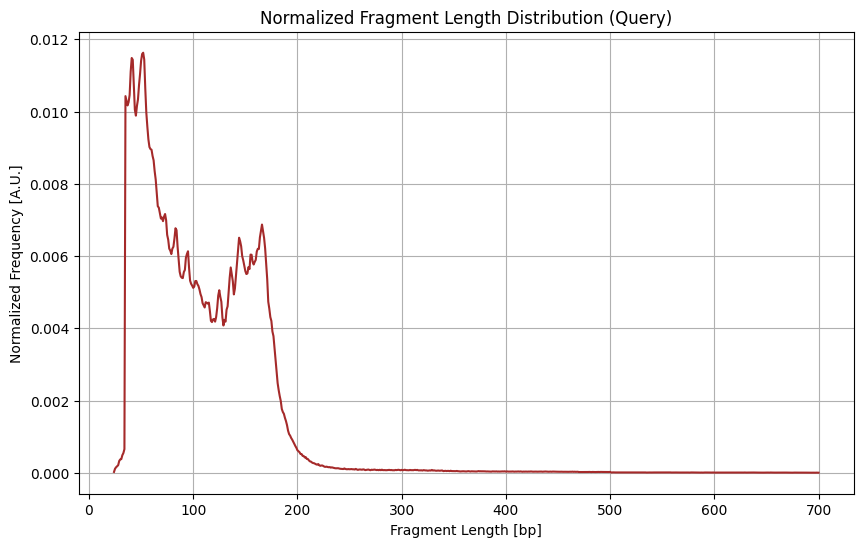

In [16]:
# Plotting normalized fragment length distribution
plt.figure(figsize=(10, 6))
plt.plot(sorted_lengths, norm_freq, color='brown')
plt.xlabel('Fragment Length [bp]')
plt.ylabel('Normalized Frequency [A.U.]')
plt.title('Normalized Fragment Length Distribution (Query)')
plt.grid(True)
plt.show()

In [17]:
#  Load reference distribution
reference = pd.read_csv('reference.hist', sep='\t', header=None, names=['length', 'ref_freq'])
reference = reference.dropna()

In [18]:
# Buffers to store sampled fragment lengths
sampled_fragments = defaultdict(list)

# Dictionary to store how many fragments we need per length
fragments_needed = {}

# Normalize reference frequencies and compute how many fragments to keep for each length
total_reference_freq = reference['ref_freq'].sum()
for _, row in reference.iterrows():
    fragment_length = int(row['length'])
    required_count = int((row['ref_freq'] / total_reference_freq) * fragment_total)
    fragments_needed[fragment_length] = required_count

# Stream through the query BED file and collect only the needed number of each fragment length
with open('query.bed', 'rt') as file:
    for line in file:
        columns = line.strip().split()
        try:
            start = int(columns[1])
            end = int(columns[2])
            length = end - start
            if length > 0 and length in fragments_needed:
                buffer = sampled_fragments[length]
                if len(buffer) < fragments_needed[length]:
                    buffer.append(length)
        except (IndexError, ValueError):
            continue


In [19]:
# Aggregate resampled fragment lengths from all buffers
resampled_counts = {length: len(buffer) for length, buffer in sampled_fragments.items()}

# Total number of resampled fragments
total_resampled = sum(resampled_counts.values())

# Sort the lengths for plotting
resampled_lengths_sorted = sorted(resampled_counts.keys())

# Compute normalized frequency of each resampled length
resampled_freq = [resampled_counts[length] / total_resampled for length in resampled_lengths_sorted]


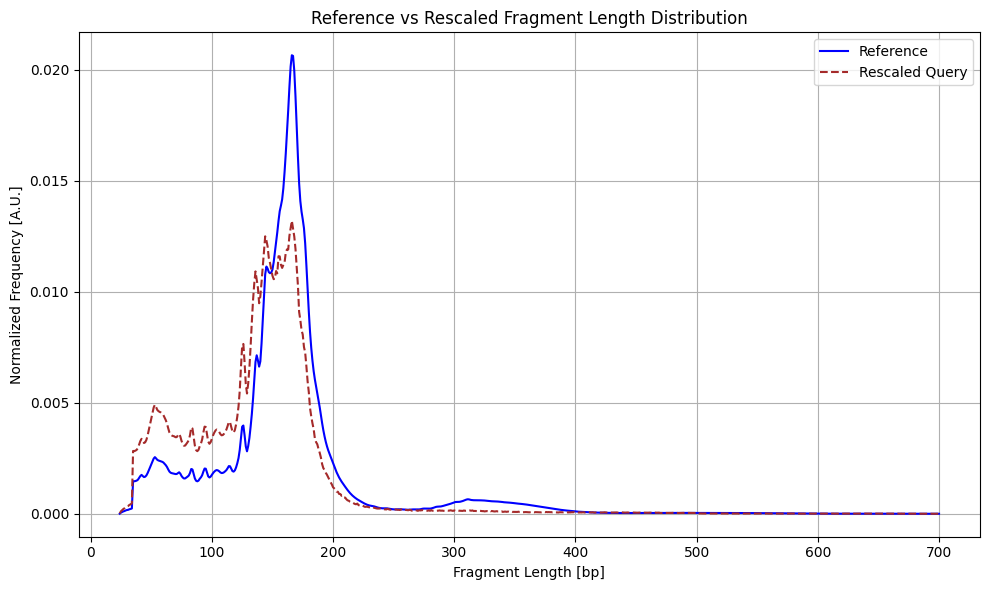

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(reference['length'], reference['ref_freq'] / reference['ref_freq'].sum(), 
         label='Reference', color='blue')
plt.plot(resampled_lengths_sorted, resampled_freq, 
         label='Rescaled Query', color='brown', linestyle='--')
plt.xlabel('Fragment Length [bp]')
plt.ylabel('Normalized Frequency [A.U.]')
plt.title('Reference vs Rescaled Fragment Length Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
